In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.2.2 
2: package ‘datasets’ was built under R version 4.2.2 
3: package ‘utils’ was built under R version 4.2.2 
4: package ‘grDevices’ was built under R version 4.2.2 
5: package ‘graphics’ was built under R version 4.2.2 
6: package ‘stats’ was built under R version 4.2.2 


In [2]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [3]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/miR.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


In [4]:
#meta data prior to filtering
meta = adata.obs
meta.head()

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   

                                   barcode            guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC  hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT    hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT  hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA        TuD_NC_18  5.859895   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT  hsa-miR-147b-5p  5.632808   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0  ...   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  ...   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  ...   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  ...   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   

                          seurat_clusters guide_group  \
miR_1:AAACCCAAGGAGAGGC-1               T2      target   
miR_1:AAACCCAAGGTAAACT-1               T0      target   
miR_1:AAACCCACAACGATCT-1               T0      target   
miR_1:AAACCCACACGATTCA-1          control     control   
miR_1:AAACCCACAGTCAACT-1               T8      target   

                                        miR.family  
miR_1:AAACCCAAGGAGAGGC-1             miR-203a-3p.1  
miR_1:AAACCCAAGGTAAACT-1                 miR-93-3p  
miR_1:AAACCCACAACGATCT-1  miR-130-3p/301-3p/454-3p  
miR_1:AAACCCACACGATTCA-1                        NA  
miR_1:AAACCCACAGTCAACT-1                  miR-147b  

[5 rows x 21 columns]

In [5]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = type
count_df

guide  cells          type
0         TuD_NC_01   1665       control
1         TuD_NC_02     49       control
2         TuD_NC_03     80       control
3         TuD_NC_04     72       control
4         TuD_NC_05     57       control
..              ...    ...           ...
392   hsa-miR-96-5p     72  perturbation
393   hsa-miR-98-3p     81  perturbation
394    hsa-miR-9903     78  perturbation
395  hsa-miR-99b-3p     71  perturbation
396  hsa-miR-99b-5p     74  perturbation

[397 rows x 3 columns]

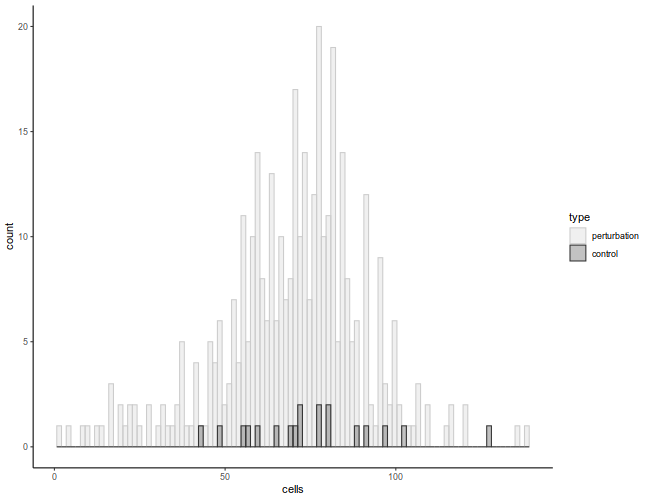

In [6]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

In [7]:
# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)

In [8]:
adata.uns['processed'] = True

In [9]:
#meta data post-filtering
meta = adata.obs
meta

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_2:GATCGTATCAGCCTTC-1        miR     29425.0          5742  miR_2   
miR_1:GATTGGTTCTTCCTAA-1        miR     25780.0          5864  miR_1   
miR_2:AGACTCAAGAAGTCCG-1        miR     14697.0          4471  miR_2   
miR_1:ACGCACGAGGATTTCC-1        miR     39019.0          7134  miR_1   
miR_2:AACCTTTTCGTTCAGA-1        miR      9897.0          3360  miR_2   
...                             ...         ...           ...    ...   
miR_2:CTGCATCCACATTGTG-1        miR     62537.0          8331  miR_2   
miR_1:CGTTCTGAGCCTAACT-1        miR     26147.0          5444  miR_1   
miR_1:CCCGAAGTCTGCGTCT-1        miR     98769.0          9485  miR_1   
miR_1:TAGGTTGGTGTCCGGT-1        miR     35327.0          6686  miR_1   
miR_1:TGTTACTAGATCCGAG-1        miR     41278.0          7378  miR_1   

                                   barcode            guide       lor  \
miR_2:GATCGTATCAGCCTTC-1  GATCGTATCAGCCTTC        TuD_NC_01  2.184182   
miR_1:GATTGGTTCTTCCTAA-1  GATTGGTTCTTCCTAA        TuD_NC_01  4.268533   
miR_2:AGACTCAAGAAGTCCG-1  AGACTCAAGAAGTCCG        TuD_NC_01  2.104026   
miR_1:ACGCACGAGGATTTCC-1  ACGCACGAGGATTTCC        TuD_NC_01  3.581581   
miR_2:AACCTTTTCGTTCAGA-1  AACCTTTTCGTTCAGA        TuD_NC_01  2.740359   
...                                    ...              ...       ...   
miR_2:CTGCATCCACATTGTG-1  CTGCATCCACATTGTG  hsa-miR-301a-5p  3.142209   
miR_1:CGTTCTGAGCCTAACT-1  CGTTCTGAGCCTAACT  hsa-miR-301a-5p  4.643408   
miR_1:CCCGAAGTCTGCGTCT-1  CCCGAAGTCTGCGTCT  hsa-miR-301a-5p  3.945098   
miR_1:TAGGTTGGTGTCCGGT-1  TAGGTTGGTGTCCGGT  hsa-miR-301a-5p  4.418603   
miR_1:TGTTACTAGATCCGAG-1  TGTTACTAGATCCGAG  hsa-miR-301a-5p  0.564128   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_2:GATCGTATCAGCCTTC-1   1.434750e-16   1.493253e-09     14.0  ...   
miR_1:GATTGGTTCTTCCTAA-1   1.806145e-70   1.822858e-63     57.0  ...   
miR_2:AGACTCAAGAAGTCCG-1   1.230159e-19   1.280319e-12     14.0  ...   
miR_1:ACGCACGAGGATTTCC-1   1.827343e-44   1.844253e-37     41.0  ...   
miR_2:AACCTTTTCGTTCAGA-1   3.408524e-27   3.547507e-20     20.0  ...   
...                                 ...            ...      ...  ...   
miR_2:CTGCATCCACATTGTG-1  4.940656e-324  5.142113e-317    148.0  ...   
miR_1:CGTTCTGAGCCTAACT-1   3.819092e-98   3.854432e-91     36.0  ...   
miR_1:CCCGAAGTCTGCGTCT-1  4.940656e-324  4.986374e-317    176.0  ...   
miR_1:TAGGTTGGTGTCCGGT-1   2.053056e-88   2.072054e-81     35.0  ...   
miR_1:TGTTACTAGATCCGAG-1   1.006841e-07   1.000000e+00      2.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_2:GATCGTATCAGCCTTC-1  0.073048   0.527479     1.146128   1.462398   
miR_1:GATTGGTTCTTCCTAA-1  0.196474   8.223927     1.755875   1.892095   
miR_2:AGACTCAAGAAGTCCG-1  0.052897   0.509821     1.146128   1.322219   
miR_1:ACGCACGAGGATTTCC-1  0.181360   4.300359     1.612784   1.857332   
miR_2:AACCTTTTCGTTCAGA-1  0.073048   1.032529     1.301030   1.462398   
...                            ...        ...          ...        ...   
miR_2:CTGCATCCACATTGTG-1  0.677582  57.582653     2.170262   2.429752   
miR_1:CGTTCTGAGCCTAACT-1  0.103275   3.274661     1.556303   1.612784   
miR_1:CCCGAAGTCTGCGTCT-1  0.712846  83.482991     2.245513   2.451786   
miR_1:TAGGTTGGTGTCCGGT-1  0.125945   3.150765     1.544068   1.698970   
miR_1:TGTTACTAGATCCGAG-1  0.015113   0.019973     0.301030   0.778151   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_2:GATCGTATCAGCCTTC-1  -1.136393    5.454545                       2   
miR_1:GATTGGTTCTTCCTAA-1  -0.706696    5.543057                       0   
miR_2:AGACTCAAGAAGTCCG-1  -1.276571    9.239981                       0   
miR_1:ACGCACGAGGATTTCC-1  -0.741458    8.008919                       3   
miR_2:AACCTTTTCGTTCAGA-1  -1.136393    7.921592                       1   
...                             ...         ...                     ...   
miR_2:CTGCATCCAC

# E-distance

In [10]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 341/341 [02:19<00:00,  2.44it/s]


In [11]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [12]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_estats_mtx_separate_controls_without_miR_families.csv')
estats.head()

TuD_NC_01  hsa-miR-3605-5p  hsa-miR-122-5p  TuD_NC_18  \
TuD_NC_01          0.000000        -6.968253      -12.695165 -13.835536   
hsa-miR-3605-5p   -6.968253         0.000000       -6.027700   3.921944   
hsa-miR-122-5p   -12.695165        -6.027700        0.000000  -6.602918   
TuD_NC_18        -13.835536         3.921944       -6.602918   0.000000   
hsa-miR-10527-5p  -7.656030        17.204695        0.610728 -16.277560   

                  hsa-miR-10527-5p  hsa-miR-1255a  hsa-miR-4677-3p  \
TuD_NC_01                -7.656030      -7.211906       -18.895072   
hsa-miR-3605-5p          17.204695      17.808202         3.399776   
hsa-miR-122-5p            0.610728      11.190995        -9.039345   
TuD_NC_18               -16.277560     -14.218099       -20.546397   
hsa-miR-10527-5p          0.000000      -2.876531       -17.975692   

                  hsa-miR-3928-3p  hsa-miR-3662  hsa-miR-489-3p  ...  \
TuD_NC_01               -0.822229      4.310983       11.151866  ...   
hsa-miR-3605-5p          0.785030      3.230444        7.164816  ...   
hsa-miR-122-5p          -4.194344     -4.551327        2.044884  ...   
TuD_NC_18               -2.759675     -2.886251        4.095106  ...   
hsa-miR-10527-5p        10.488874      6.261269       16.654406  ...   

                  hsa-miR-33a-5p  hsa-let-7f-2-3p  hsa-miR-125b-5p  \
TuD_NC_01               0.099620       -10.775436        -0.137902   
hsa-miR-3605-5p        21.252915         6.120468        13.418509   
hsa-miR-122-5p          1.360438        -7.975446         5.686605   
TuD_NC_18             -14.840261        -7.328969       -11.095205   
hsa-miR-10527-5p       -8.984752       -11.943152        -4.266245   

                  hsa-miR-454-3p  hsa-miR-196a-5p  hsa-miR-191-5p  \
TuD_NC_01              -0.908190        -1.140397       -4.419797   
hsa-miR-3605-5p        20.815733        17.240971       24.567508   
hsa-miR-122-5p          8.772339        -0.885916       -1.023723   
TuD_NC_18              -1.939635        -4.709165      -15.056304   
hsa-miR-10527-5p      -12.383301        -9.257807      -15.236909   

                  hsa-miR-30c-5p  hsa-miR-660-5p  hsa-miR-4742-3p  \
TuD_NC_01              -6.916097       16.961226        -6.085497   
hsa-miR-3605-5p        -9.425687       31.438078        17.920479   
hsa-miR-122-5p         -7.368477       24.265359         3.474837   
TuD_NC_18              -6.159688       -4.201212       -12.162305   
hsa-miR-10527-5p       -1.853936        0.703317       -13.550375   

                  hsa-miR-301a-5p  
TuD_NC_01               -2.424355  
hsa-miR-3605-5p        -15.892466  
hsa-miR-122-5p          -1.788890  
TuD_NC_18                4.681899  
hsa-miR-10527-5p        18.768567  

[5 rows x 341 columns]

E-distance relative to control KD (plotted better in R below)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


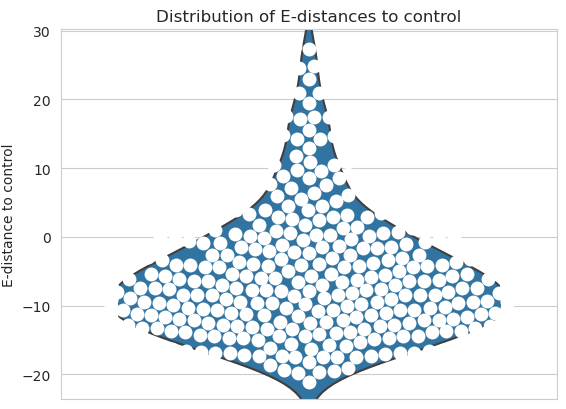

In [13]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC_04'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC_04'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




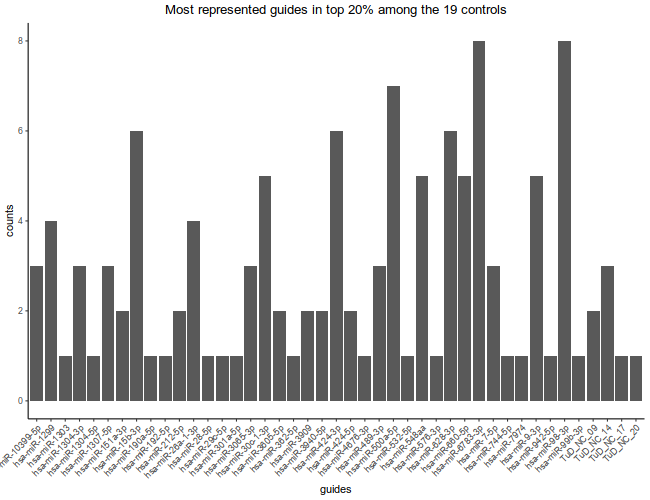

In [14]:
%%R -i estats -w 650 -h 500
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls

startsWith(colnames(estats), prefix = 'TuD') -> status
names <- rownames(estats)[status]
tp20_pct = rep(list(matrix(0,5,5)), length(names))
dotplot = rep(list(matrix(0,5,5)), length(names))
for (i in 1:length(names)){
  startsWith(colnames(estats), prefix = 'TuD') -> status
  control_status = 1:length(status)
  control_status[status] <- 'control'
  control_status[!status] <- 'perturbation'
  estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,names[i]], guide = control_status, guide_nm = rownames(estats))
  estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
  estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
  tp20_pct[[i]] <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
  dotplot[[i]] = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle(names[i])
}

names(dotplot) <- names

## given that each of the top 20% of guides are different based on
## which control you're comparing to, we take top 20% guides from 5 sampled controls
## and find intersecting guides among the 5.
## we repeat this process 10 times (hopefully drawing different controls each time) 
## and draw a histogram to find most common guides

set.seed(44)
nms_list = replicate(10, Reduce(intersect, sample(tp20_pct, 5, replace = FALSE)))
nms = unlist(nms_list)
df = data.frame(guides = nms)
df = count(df, guides, name = 'counts')

barpl <- ggplot(df, aes(x = guides, y = counts)) + geom_col() + theme_classic() + ggtitle('Most represented guides in top 20% among the 19 controls') +
  theme(axis.text.x = element_text(angle = 45, hjust=1), plot.title = element_text(hjust = 0.5)) 


pdf('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_perturbs_to_varying_controls_without_miR_families.pdf', height = 4, width = 5)
print(barpl)
for (i in 1:length(names)){
  print(dotplot[[i]])
}
dev.off()

barpl

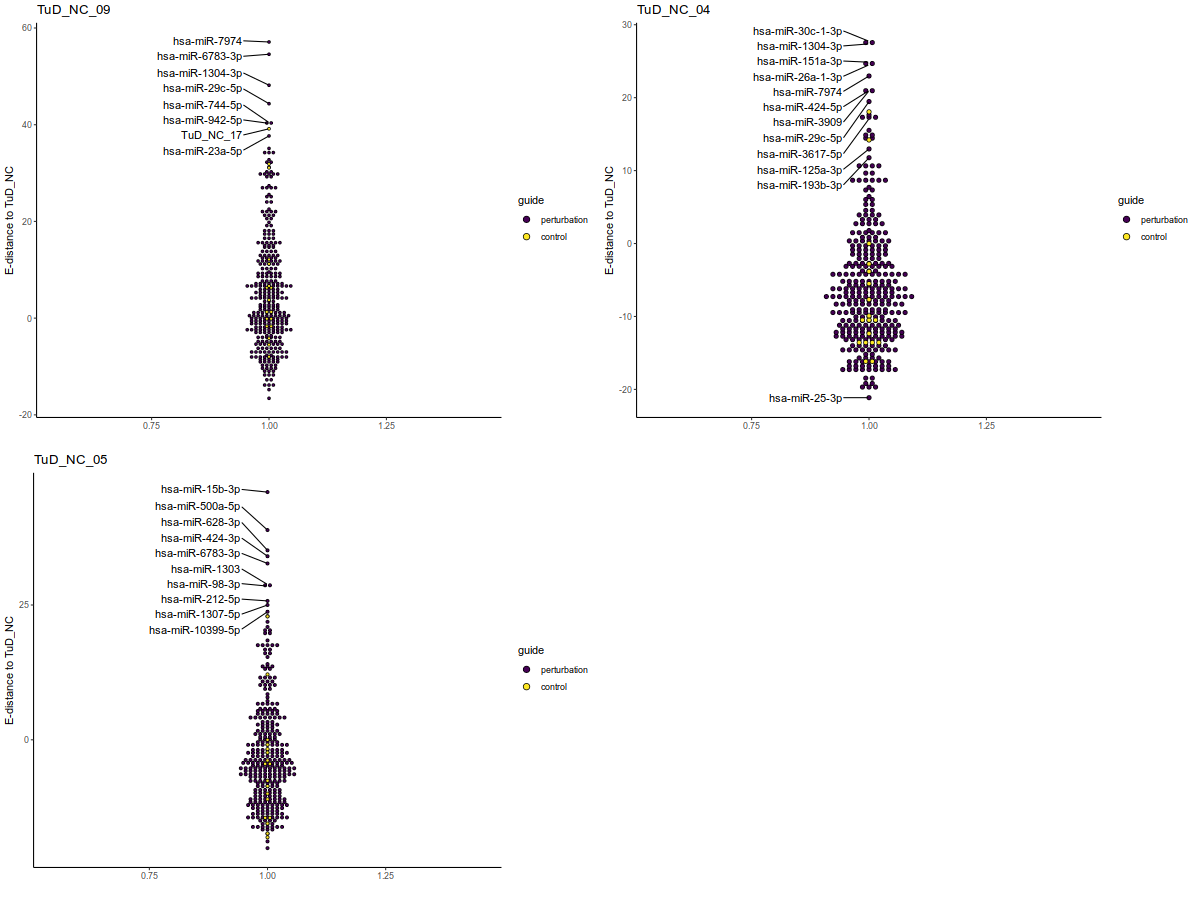

In [15]:
%%R -w 1200 -h 900
## representative controls for barplot above
controls_to_plot <- c('TuD_NC_09', 'TuD_NC_04', 'TuD_NC_05', 'TuD_NC_02')
ggarrange(plotlist = dotplot[controls_to_plot], nrow = 2, ncol = 2)


Heatmap of pariwise E-distances of perturbations to each other

In [16]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_separate_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [17]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_color2_separate_controls_without_miR_families.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [18]:
## perform e-testing using each control guide (slow ~ 5hrs)
# e-testing -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
ctrls = pd.Series(list(set(meta.loc[:,'guide'])))
ctrls = ctrls[ctrls.str.startswith('TuD')].sort_values().reset_index(drop=True)
prep_dict = dict(zip(ctrls, [0 for x in ctrls]))

for x in ctrls:
    prep_dict[x] = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control=x, alpha=0.05, runs=100)

100%|██████████| 100/100 [07:38<00:00,  4.59s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [07:36<00:00,  4.56s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [07:03<00:00,  4.24s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [07:03<00:00,  4.23s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [07:34<00:00,  4.55s/it]
/home/ssobti/miniconda3/envs/mirtud_env/li

In [19]:
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_prep_dict_controls_separate_without_miR_families.out'
my_shelf = shelve.open(filenm,'n') # 'n' for new
vec = ['estats', 'prep_dict', 'ctrls']
for key in vec:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
    except pickle.PicklingError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

In [20]:
## load saved data
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_prep_dict_controls_separate_without_miR_families.out'
my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [21]:
## pull out pvalues in prep_dict for each control run and put into a new df (pvals_df)
pvals_df = pd.DataFrame()
for x in ctrls:
    try:
        pvals_df.loc[:,x] = prep_dict[x].loc[:, 'pvalue']
    except KeyError:
        print(x + ' was not calculated')

In [22]:
pvals_df

TuD_NC_01  TuD_NC_03  TuD_NC_04  TuD_NC_05  TuD_NC_06  \
TuD_NC_01            0.00       0.97       0.88       0.72       1.00   
TuD_NC_03            0.96       0.00       0.92       0.98       0.84   
TuD_NC_04            0.87       0.90       0.00       0.53       0.75   
TuD_NC_05            0.75       0.97       0.47       0.00       0.87   
TuD_NC_06            0.99       0.82       0.83       0.85       0.00   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p        0.95       1.00       0.85       0.72       0.42   
hsa-miR-98-3p        0.34       0.14       0.58       0.04       0.18   
hsa-miR-9903         0.40       0.32       0.81       0.10       0.32   
hsa-miR-99b-3p       0.45       0.14       0.80       0.09       0.44   
hsa-miR-99b-5p       0.28       0.75       0.38       0.90       0.96   

                TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  TuD_NC_11  \
TuD_NC_01            0.77       0.80       0.40       0.77       0.45   
TuD_NC_03            0.84       1.00       0.27       1.00       0.81   
TuD_NC_04            0.95       0.85       0.57       0.97       0.82   
TuD_NC_05            0.53       0.98       0.13       0.95       0.57   
TuD_NC_06            0.68       0.85       0.41       0.93       0.54   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p        0.87       0.96       0.15       0.84       0.76   
hsa-miR-98-3p        0.18       0.25       0.06       0.11       0.07   
hsa-miR-9903         0.94       0.50       0.39       0.42       0.54   
hsa-miR-99b-3p       0.54       0.26       0.62       0.29       0.35   
hsa-miR-99b-5p       0.60       0.75       0.15       0.94       0.77   

                TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  TuD_NC_17  \
TuD_NC_01            0.86       0.46       0.73       0.71       0.24   
TuD_NC_03            0.79       0.36       0.78       0.56       0.64   
TuD_NC_04            0.70       0.51       0.96       0.85       0.11   
TuD_NC_05            0.44       0.09       0.47       0.45       0.96   
TuD_NC_06            0.83       0.07       0.87       0.92       0.33   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p        0.48       0.70       0.81       0.62       0.24   
hsa-miR-98-3p        0.05       0.95       0.62       0.34       0.00   
hsa-miR-9903         0.32       0.74       0.72       0.71       0.03   
hsa-miR-99b-3p       0.47       0.15       0.73       0.85       0.00   
hsa-miR-99b-5p       0.60       0.01       0.33       0.50       0.60   

                TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01            0.90       0.92       0.09  
TuD_NC_03            0.96       0.91       0.54  
TuD_NC_04            0.82       0.91       0.06  
TuD_NC_05            0.79       0.75       0.97  
TuD_NC_06            0.94       0.93       0.23  
...                   ...        ...        ...  
hsa-miR-96-5p        0.93       0.91       0.21  
hsa-miR-98-3p        0.43       0.40       0.00  
hsa-miR-9903         0.76       0.65       0.02  
hsa-miR-99b-3p       0.37       0.67       0.01  
hsa-miR-99b-5p       0.77       0.74       0.60  

[341 rows x 18 columns]

In [23]:
## convert p-vals across rows (ie the comparison of each guide to the 20 controls) to z-scores
## make all p-vals of 0 equal to 0.001
pvals_df[pvals_df == 0] = 0.001
pvals_df[pvals_df == 1] = 0.999
z_scores_df = pvals_df.copy()
import scipy as sp
import math
for index, row in pvals_df.iterrows():
    z_scores_df.loc[index,:] = sp.stats.norm.ppf(1 - row)

In [24]:
## calculate combined zscores

def combine_zscores(scores):
    return sum(scores)/np.sqrt(len(scores))

zscores_comb = z_scores_df.apply(combine_zscores, axis = 1)

In [25]:
z_scores_df

TuD_NC_01  TuD_NC_03  TuD_NC_04  TuD_NC_05  TuD_NC_06  \
TuD_NC_01        3.090232  -1.880794  -1.174987  -0.582842  -3.090232   
TuD_NC_03       -1.750686   3.090232  -1.405072  -2.053749  -0.994458   
TuD_NC_04       -1.126391  -1.281552   3.090232  -0.075270  -0.674490   
TuD_NC_05       -0.674490  -1.880794   0.075270   3.090232  -1.126391   
TuD_NC_06       -2.326348  -0.915365  -0.954165  -1.036433   3.090232   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p   -1.644854  -3.090232  -1.036433  -0.582842   0.201893   
hsa-miR-98-3p    0.412463   1.080319  -0.201893   1.750686   0.915365   
hsa-miR-9903     0.253347   0.467699  -0.877896   1.281552   0.467699   
hsa-miR-99b-3p   0.125661   1.080319  -0.841621   1.340755   0.150969   
hsa-miR-99b-5p   0.582842  -0.674490   0.305481  -1.281552  -1.750686   

                TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  TuD_NC_11  \
TuD_NC_01       -0.738847  -0.841621   0.253347  -0.738847   0.125661   
TuD_NC_03       -0.994458  -3.090232   0.612813  -3.090232  -0.877896   
TuD_NC_04       -1.644854  -1.036433  -0.176374  -1.880794  -0.915365   
TuD_NC_05       -0.075270  -2.053749   1.126391  -1.644854  -0.176374   
TuD_NC_06       -0.467699  -1.036433   0.227545  -1.475791  -0.100434   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p   -1.126391  -1.750686   1.036433  -0.994458  -0.706303   
hsa-miR-98-3p    0.915365   0.674490   1.554774   1.226528   1.475791   
hsa-miR-9903    -1.554774   0.000000   0.279319   0.201893  -0.100434   
hsa-miR-99b-3p  -0.100434   0.643345  -0.305481   0.553385   0.385320   
hsa-miR-99b-5p  -0.253347  -0.674490   1.036433  -1.554774  -0.738847   

                TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  TuD_NC_17  \
TuD_NC_01       -1.080319   0.100434  -0.612813  -0.553385   0.706303   
TuD_NC_03       -0.806421   0.358459  -0.772193  -0.150969  -0.358459   
TuD_NC_04       -0.524401  -0.025069  -1.750686  -1.036433   1.226528   
TuD_NC_05        0.150969   1.340755   0.075270   0.125661  -1.750686   
TuD_NC_06       -0.954165   1.475791  -1.126391  -1.405072   0.439913   
...                   ...        ...        ...        ...        ...   
hsa-miR-96-5p    0.050154  -0.524401  -0.877896  -0.305481   0.706303   
hsa-miR-98-3p    1.644854  -1.644854  -0.305481   0.412463   3.090232   
hsa-miR-9903     0.467699  -0.643345  -0.582842  -0.553385   1.880794   
hsa-miR-99b-3p   0.075270   1.036433  -0.612813  -1.036433   3.090232   
hsa-miR-99b-5p  -0.253347   2.326348   0.439913   0.000000  -0.253347   

                TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01       -1.281552  -1.405072   1.340755  
TuD_NC_03       -1.750686  -1.340755  -0.100434  
TuD_NC_04       -0.915365  -1.340755   1.554774  
TuD_NC_05       -0.806421  -0.674490  -1.880794  
TuD_NC_06       -1.554774  -1.475791   0.738847  
...                   ...        ...        ...  
hsa-miR-96-5p   -1.475791  -1.340755   0.806421  
hsa-miR-98-3p    0.176374   0.253347   3.090232  
hsa-miR-9903    -0.706303  -0.385320   2.053749  
hsa-miR-99b-3p   0.331853  -0.439913   2.326348  
hsa-miR-99b-5p  -0.738847  -0.643345  -0.253347  

[341 rows x 18 columns]

In [26]:
zscores_comb

TuD_NC_01        -1.971550
TuD_NC_03        -3.647539
TuD_NC_04        -2.011176
TuD_NC_05        -1.593291
TuD_NC_06        -2.087505
                    ...   
hsa-miR-96-5p    -2.982887
hsa-miR-98-3p     3.894050
hsa-miR-9903      0.459490
hsa-miR-99b-3p    1.839231
hsa-miR-99b-5p   -1.032235
Length: 341, dtype: float64

In [27]:
mean_distances = estats.loc[z_scores_df.index, estats.columns.str.startswith('TuD')].mean(axis = 1)

In [28]:
## convert zscores_comb to pvalues and remove control guides from results
## remove control guides
p_vals_combined = 1 - sp.stats.norm.cdf(zscores_comb)
df_dict = {'guide' : zscores_comb.index, 'edist': mean_distances, 'pvalue_adj' : p_vals_combined}
df = pd.DataFrame(df_dict)
df = df.drop(df[df['guide'].str.startswith('TuD')].index)
df = df.reset_index(drop = True)
df['significant_adj'] = df['pvalue_adj'] < 0.05
df = df.set_index('guide')
df.index.name = None
df

edist  pvalue_adj  significant_adj
hsa-let-7a-2-3p  -5.835125    0.976552            False
hsa-let-7b-3p    -0.935727    0.483057            False
hsa-let-7f-2-3p  -6.629598    0.988882            False
hsa-let-7i-3p    -8.673804    0.999947            False
hsa-miR-100-3p   -1.734942    0.546572            False
...                    ...         ...              ...
hsa-miR-96-5p    -6.691928    0.998572            False
hsa-miR-98-3p    13.856601    0.000049             True
hsa-miR-9903      0.580758    0.322941            False
hsa-miR-99b-3p    5.107310    0.032941             True
hsa-miR-99b-5p   -3.127201    0.849019            False

[323 rows x 3 columns]

In [29]:
df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_separate_controls_without_miR_families.csv')

In [30]:
df = pd.read_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_separate_controls_without_miR_families.csv', index_col=0)
df.sort_values('pvalue_adj')
df.sort_values('pvalue_adj').iloc[0:20,:]

edist    pvalue_adj  significant_adj
hsa-miR-15b-3p    25.917934  2.055023e-13             True
hsa-miR-500a-5p   25.724571  4.179990e-13             True
hsa-miR-424-5p    22.086024  9.156189e-10             True
hsa-miR-30c-1-3p  18.684408  8.672640e-09             True
hsa-miR-26a-1-3p  18.496657  9.507432e-09             True
hsa-miR-6783-3p   19.700070  3.525960e-08             True
hsa-miR-1304-3p   15.962224  9.593593e-08             True
hsa-miR-1299      15.774913  1.676690e-07             True
hsa-miR-7974      16.771892  1.313265e-06             True
hsa-miR-660-5p    13.099432  1.547780e-06             True
hsa-miR-3909      12.412378  7.466560e-06             True
hsa-miR-548aa     14.270640  8.393541e-06             True
hsa-miR-424-3p    16.383865  9.291020e-06             True
hsa-miR-98-3p     13.856601  4.929211e-05             True
hsa-miR-1303      12.362624  6.383256e-05             True
hsa-miR-9-3p      12.515407  7.113978e-05             True
hsa-miR-151a-3p   11.651434  8.561557e-05             True
hsa-miR-212-5p    11.081323  9.839997e-05             True
hsa-miR-7-5p      10.275554  1.291640e-04             True
hsa-miR-628-3p    12.160860  3.048366e-04             True

In [31]:
df.sort_values('pvalue_adj').iloc[-5:-1,:]

edist  pvalue_adj  significant_adj
hsa-miR-590-3p  -10.760988         1.0            False
hsa-miR-1343-3p -11.946558         1.0            False
hsa-miR-503-5p  -10.448255         1.0            False
hsa-miR-550a-5p -11.743640         1.0            False

### Scatter plot of E-distance from control vs adjusted p-value

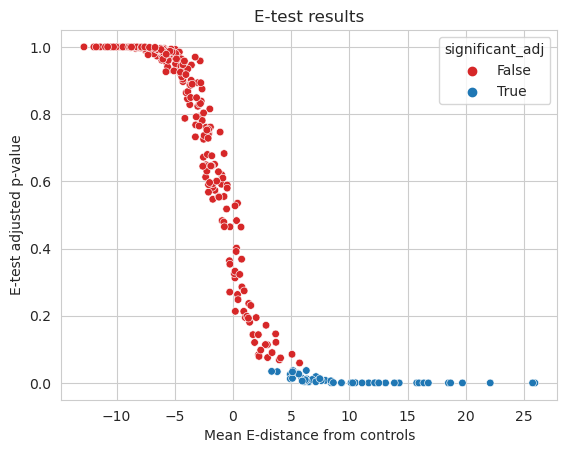

In [32]:
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red'}, s=30)
pl.title('E-test results')
pl.xlabel('Mean E-distance from controls')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [33]:
meta2 = adata.obs
meta2

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_2:GATCGTATCAGCCTTC-1        miR     29425.0          5742  miR_2   
miR_1:GATTGGTTCTTCCTAA-1        miR     25780.0          5864  miR_1   
miR_2:AGACTCAAGAAGTCCG-1        miR     14697.0          4471  miR_2   
miR_1:ACGCACGAGGATTTCC-1        miR     39019.0          7134  miR_1   
miR_2:AACCTTTTCGTTCAGA-1        miR      9897.0          3360  miR_2   
...                             ...         ...           ...    ...   
miR_2:CTGCATCCACATTGTG-1        miR     62537.0          8331  miR_2   
miR_1:CGTTCTGAGCCTAACT-1        miR     26147.0          5444  miR_1   
miR_1:CCCGAAGTCTGCGTCT-1        miR     98769.0          9485  miR_1   
miR_1:TAGGTTGGTGTCCGGT-1        miR     35327.0          6686  miR_1   
miR_1:TGTTACTAGATCCGAG-1        miR     41278.0          7378  miR_1   

                                   barcode            guide       lor  \
miR_2:GATCGTATCAGCCTTC-1  GATCGTATCAGCCTTC        TuD_NC_01  2.184182   
miR_1:GATTGGTTCTTCCTAA-1  GATTGGTTCTTCCTAA        TuD_NC_01  4.268533   
miR_2:AGACTCAAGAAGTCCG-1  AGACTCAAGAAGTCCG        TuD_NC_01  2.104026   
miR_1:ACGCACGAGGATTTCC-1  ACGCACGAGGATTTCC        TuD_NC_01  3.581581   
miR_2:AACCTTTTCGTTCAGA-1  AACCTTTTCGTTCAGA        TuD_NC_01  2.740359   
...                                    ...              ...       ...   
miR_2:CTGCATCCACATTGTG-1  CTGCATCCACATTGTG  hsa-miR-301a-5p  3.142209   
miR_1:CGTTCTGAGCCTAACT-1  CGTTCTGAGCCTAACT  hsa-miR-301a-5p  4.643408   
miR_1:CCCGAAGTCTGCGTCT-1  CCCGAAGTCTGCGTCT  hsa-miR-301a-5p  3.945098   
miR_1:TAGGTTGGTGTCCGGT-1  TAGGTTGGTGTCCGGT  hsa-miR-301a-5p  4.418603   
miR_1:TGTTACTAGATCCGAG-1  TGTTACTAGATCCGAG  hsa-miR-301a-5p  0.564128   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_2:GATCGTATCAGCCTTC-1   1.434750e-16   1.493253e-09     14.0  ...   
miR_1:GATTGGTTCTTCCTAA-1   1.806145e-70   1.822858e-63     57.0  ...   
miR_2:AGACTCAAGAAGTCCG-1   1.230159e-19   1.280319e-12     14.0  ...   
miR_1:ACGCACGAGGATTTCC-1   1.827343e-44   1.844253e-37     41.0  ...   
miR_2:AACCTTTTCGTTCAGA-1   3.408524e-27   3.547507e-20     20.0  ...   
...                                 ...            ...      ...  ...   
miR_2:CTGCATCCACATTGTG-1  4.940656e-324  5.142113e-317    148.0  ...   
miR_1:CGTTCTGAGCCTAACT-1   3.819092e-98   3.854432e-91     36.0  ...   
miR_1:CCCGAAGTCTGCGTCT-1  4.940656e-324  4.986374e-317    176.0  ...   
miR_1:TAGGTTGGTGTCCGGT-1   2.053056e-88   2.072054e-81     35.0  ...   
miR_1:TGTTACTAGATCCGAG-1   1.006841e-07   1.000000e+00      2.0  ...   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_2:GATCGTATCAGCCTTC-1  0.073048   0.527479     1.146128   1.462398   
miR_1:GATTGGTTCTTCCTAA-1  0.196474   8.223927     1.755875   1.892095   
miR_2:AGACTCAAGAAGTCCG-1  0.052897   0.509821     1.146128   1.322219   
miR_1:ACGCACGAGGATTTCC-1  0.181360   4.300359     1.612784   1.857332   
miR_2:AACCTTTTCGTTCAGA-1  0.073048   1.032529     1.301030   1.462398   
...                            ...        ...          ...        ...   
miR_2:CTGCATCCACATTGTG-1  0.677582  57.582653     2.170262   2.429752   
miR_1:CGTTCTGAGCCTAACT-1  0.103275   3.274661     1.556303   1.612784   
miR_1:CCCGAAGTCTGCGTCT-1  0.712846  83.482991     2.245513   2.451786   
miR_1:TAGGTTGGTGTCCGGT-1  0.125945   3.150765     1.544068   1.698970   
miR_1:TGTTACTAGATCCGAG-1  0.015113   0.019973     0.301030   0.778151   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_2:GATCGTATCAGCCTTC-1  -1.136393    5.454545                       2   
miR_1:GATTGGTTCTTCCTAA-1  -0.706696    5.543057                       0   
miR_2:AGACTCAAGAAGTCCG-1  -1.276571    9.239981                       0   
miR_1:ACGCACGAGGATTTCC-1  -0.741458    8.008919                       3   
miR_2:AACCTTTTCGTTCAGA-1  -1.136393    7.921592                       1   
...                             ...         ...                     ...   
miR_2:CTGCATCCAC

In [34]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [35]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [36]:
%%R -i meta2
library(stringr)
set.seed(5)
control_idxs = which(str_sub(meta2$guide, start = 1, end = 6) == 'TuD_NC')
control_idxs = sample(control_idxs, 50)

far_guide_of_interest = 'hsa-miR-15b-3p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[control_idxs] <- 'control'

close_guide_of_interest = 'hsa-miR-23b-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[control_idxs] <- 'control'

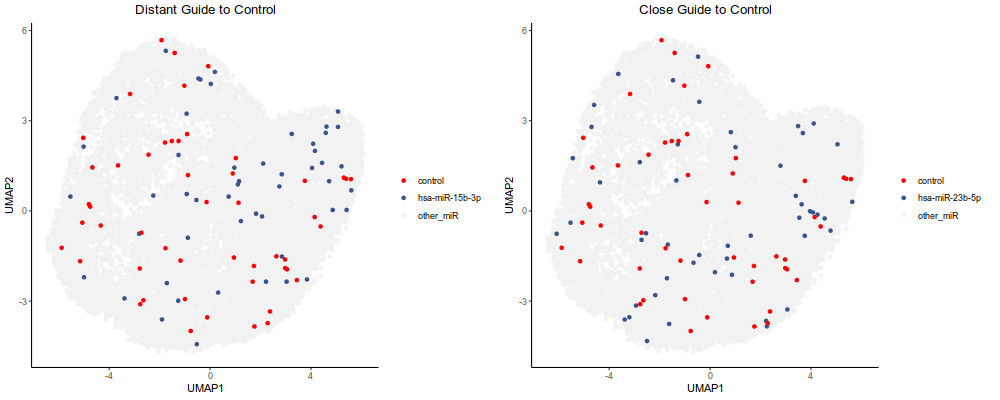

In [37]:
%%R -i nn -h 400 -w 1000

## showing the most distant and least distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

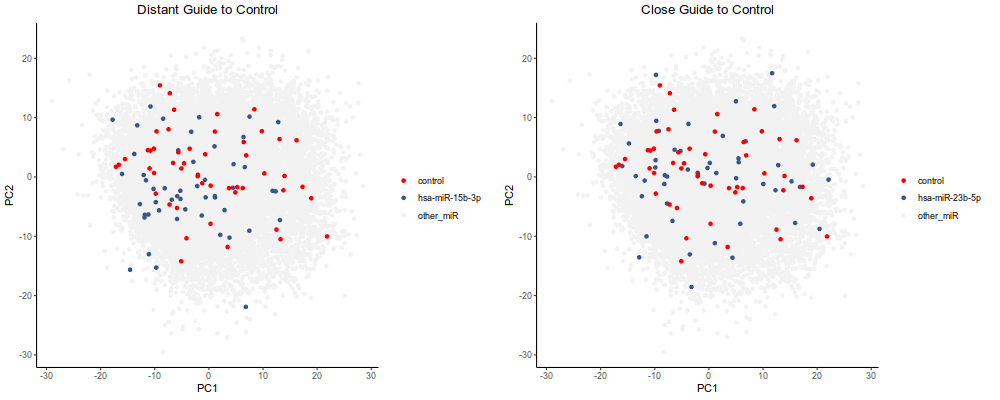

In [38]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant and least distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)